# Abstract

We evaluate the performance of a NAR-based, a file-based (uncompressed and xz-compressed) and a casync-based substitution mechanism through 3 scenarios:

1. A curl-induced mass rebuild impact on a NixOS machine closure.
1. A single derivation version bump (Firefox) impact on the said derivation.
1. A stable -> unstable channel jump impact on a NixOS machine closure.

For each of these scenarios, we compare how much data the substitution technique required to transfer versus how much data the NAR substitution required to transfer.

Unsurprisingly, the mass rebuild scenario is the one for which we see the biggest improvement: nix-casync cuts down by 48.7% the amount of downloaded data, the xz-compressed file-based substitution cuts down the same amount by 38.4%.

Surprisingly, we see an improvement in the case of a Nixpkgs stable (21.11) -> Nixpkgs unstable (20.05 pre-release) jump: xz-compressed file based substitution cuts down by 18% the amount of downloaded data, Casync by 17.2%.

We see almost no improvements for the derivation bump scenario: xz-compressed file based substitution 1%, Casync 1%.

For file substitution, we can see that the compression is crutial for the overall performance. Uncompressed file-based substitution is consistently 2 order of magnitude worse than the NAR-based substitution.

We can conclude that reducing the substitution granularity, either via Casync of xz-compressed file-based substitution consistently reduces (1% -> 48.7%) the amount of transferred data in 3 different common scenarios.

# Import Benchmark Data

In [1]:
import pandas as pd

def toMb(b):
    return b * (9.537e-7)

First, let's import the data generated by the `../companeSubsEfficiency` benchmark.

In [2]:
results_dir='bench-results'
def importBenchmarkCSVs(contentDir):
    return {
        "casync": pd.read_csv(f"{contentDir}/casync.csv",";"),
        "file": pd.read_csv(f"{contentDir}/file.csv",";"),
        "compressed-file": pd.read_csv(f"{contentDir}/file-xz-compressed.csv",";"),
        "nar": pd.read_csv(f"{contentDir}/nar.csv",";"),
    }

b = {
    "massRebuild": {
        "before": importBenchmarkCSVs(f"{results_dir}/before-mass-rebuild"),
        "after": importBenchmarkCSVs(f"{results_dir}/after-mass-rebuild"),
    },
    "channelJump": {
        "before": importBenchmarkCSVs(f"{results_dir}/nixpkgs-stable-channel"),
        "after": importBenchmarkCSVs(f"{results_dir}/nixpkgs-unstable-channel")
    },
    "firefoxBump": {
        "before": importBenchmarkCSVs(f"{results_dir}/before-firefox-bump"),
        "after": importBenchmarkCSVs(f"{results_dir}/after-firefox-bump")
    }
}

# Methodology

For each of these benchmarks, we're going to evaluate different store path substitution techniques and compare their efficiencies.

The following benchmarks will consist in building a NixOS machine configuration against 2 Nixpkgs commits. We'll simulate a NixOS machine update from the first commit to the second one.

We're going to evaluate the 3 following substitution techniques:

1. **Nar substitution**: This is the substitution model currently used by both the NixOS and Guix project. It consists in `.tar.xz`-ing a full store path. In this benchmark, we'll identify each NAR by its filename, which is derived by the `sha256` sum of their content.
1. **Casync substitution**: This is an experimental substitution method implemented via the [nix-casync](https://github.com/flokli/nix-casync) project. Here, starting from a NAR, we uncompress it and chunk it in smaller bits. In this benchmark, we'll identify each casync chunk by its filename, which is already derived the `sha256` sum of its content.
1. **File-based substitution**: This is a substitution method [the Guix](https://lists.gnu.org/archive/html/guix-devel/2021-01/msg00079.html) project brainstormed around. Basically, each store file would be served separately. In this benchmark, we'll identify these files using the `sha256` sum of their content.
1. **XZ-Compressed File-based substitution**: Similar to the File-based substitution but with each file individually compressed using the xz compression algorithm using the profile 6 extreme.


Note: we're using NixOS/Nixpkgs for all these benchmarks. However, since Guix currently use the same substitution mechanism, you can safely assume the same conclusions holds true for it as well.

In [3]:
def analyse_benchmark_results(i):
    """
    Analyse a benchmark results.
    
    :param i: benchmark dataframes. Expecting a "before" and a "after" dataframe.
    
    Each benchmark simulates the substitutions triggered by transition between two
    nix closures, a "before" and a "after" one.
    
    For each substitution mechanism, we then simulate what we can re-use and have 
    to download by diff-ing the substitution atoms (file, chunk or NAR).
    """
    
    _a_nar = i["after"]["nar"]
    _b_nar = i["before"]["nar"]
    _a_casync = i["after"]["casync"]
    _b_casync = i["before"]["casync"]
    _a_file = i["after"]["file"]
    _b_file = i["before"]["file"]
    _a_compressed_file = i["after"]["compressed-file"]
    _b_compressed_file = i["before"]["compressed-file"]

    nar_closure_size = _a_nar["Nar Size"].sum()
    casync_closure_size = _a_casync["Chunk Size"].sum()
    file_closure_size = _a_file["Size"].sum()
    compressed_file_closure_size = _a_compressed_file["Size"].sum()
    
    _nar_merged = _a_nar.merge(_b_nar, how = "left", on="Nar Name", indicator=True, suffixes=("_after","_before"))
    nar_dl_size = _nar_merged.loc[_nar_merged["_merge"] == "left_only"]["Nar Size_after"].sum()
    nar_reused_size = _nar_merged.loc[_nar_merged["_merge"] == "both"]["Nar Size_after"].sum()
    nar_nar_savings = 0
    
    _casync_merged = _a_casync.merge(_b_casync, how="left", on="Chunk Name", indicator=True, suffixes=("_after","_before"))
    casync_dl_size = _casync_merged.loc[_casync_merged["_merge"]=="left_only"]["Chunk Size_after"].sum()
    casync_reused_size = _casync_merged.loc[_casync_merged["_merge"]=="both"]["Chunk Size_after"].sum()
    casync_nar_savings = (nar_dl_size - casync_dl_size) / nar_dl_size
    
    _file_merged = _a_file.merge(_b_file, how="left", on="Sha256", indicator=True, suffixes=("_after","_before"))
    file_dl_size = _file_merged.loc[_file_merged["_merge"]=="left_only"]["Size_after"].sum()
    file_reused_size = _file_merged.loc[_file_merged["_merge"]=="both"]["Size_after"].sum()
    file_nar_savings = (nar_dl_size - file_dl_size) / nar_dl_size

    _compressed_file_merged = _a_compressed_file.merge(_b_compressed_file, how="left", on="Sha256", indicator=True, suffixes=("_after","_before"))
    compressed_file_dl_size = _compressed_file_merged.loc[_compressed_file_merged["_merge"]=="left_only"]["Size_after"].sum()
    compressed_file_reused_size = _compressed_file_merged.loc[_compressed_file_merged["_merge"]=="both"]["Size_after"].sum()
    compressed_file_nar_savings = (nar_dl_size - compressed_file_dl_size) / nar_dl_size
    
    return pd.DataFrame( data = {
        "Name": ["NAR", "Casync", "File", "Compressed File"],
        "Closure Size (MB)": [toMb(nar_closure_size), toMb(casync_closure_size), toMb(file_closure_size), toMb(compressed_file_closure_size)],
        "Downloaded Size (MB)": [toMb(nar_dl_size), toMb(casync_dl_size), toMb(file_dl_size), toMb(compressed_file_dl_size)],
        "Re-used Size (MB)": [toMb(nar_reused_size), toMb(casync_reused_size), toMb(file_reused_size), toMb(compressed_file_reused_size)],
        "DL Savings Compared to NAR (%)": [nar_nar_savings * 100, casync_nar_savings * 100, file_nar_savings * 100, compressed_file_nar_savings * 100]
    })

def gen_perf_pie(dataframe, key):
    idx=mass_rebuild_results.query(f'Name == "{key}"').index[0]
    pd.DataFrame(data={"data":[dataframe["Downloaded Size (MB)"][idx],dataframe["Re-used Size (MB)"][idx]]},\
             index=["Downloaded","Re-Used"])\
             .plot.pie(figsize=(6,6), y="data", ylabel="", title=f"{key} Downloaded/Re-Used Data")  

# Benchmark Scenarios


## 1. Mass Rebuild

Let's build the same NixOS machine description using two Nixpkgs commits: one before and one after the [staging next 2021-12-03](https://github.com/NixOS/nixpkgs/pull/148396) iteration merge to master. This staging iteration contains, among other things, a `curl` version bump. That `curl` version bump triggers a almost entire Nixpkgs mass rebuild: both `nix` and `stdenv` are depending on it.

This mass-rebuild scenario represents a long-standing issue in terms of substitution performance.

In [4]:
mass_rebuild_results = analyse_benchmark_results(b["massRebuild"])

### NAR Substitution Performance

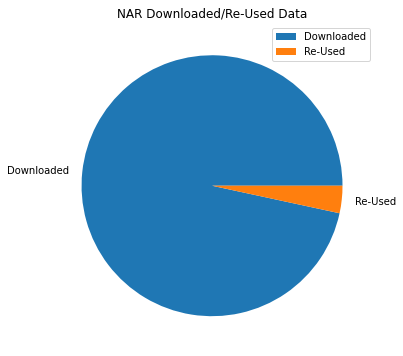

In [5]:
gen_perf_pie(mass_rebuild_results, "NAR")

### Casync Substitution Performance

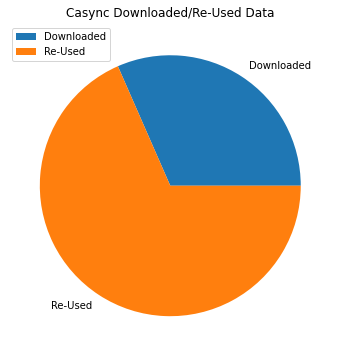

In [6]:
gen_perf_pie(mass_rebuild_results, "Casync")                 

### File-Based Substitution Performance

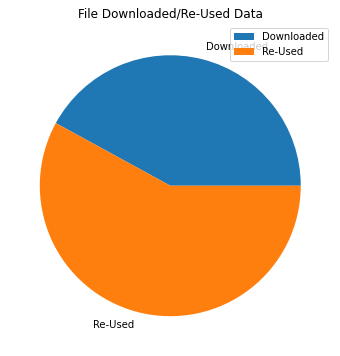

In [7]:
gen_perf_pie(mass_rebuild_results, "File")

### Compressed File-Based Substitution Performance

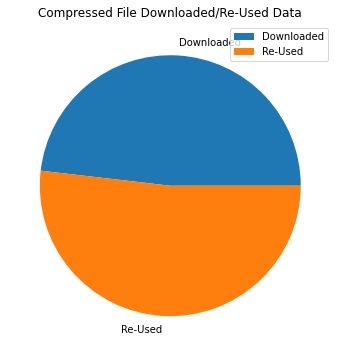

In [8]:
gen_perf_pie(mass_rebuild_results, "Compressed File")

### Comparing the Substitution Techniques


In [9]:
mass_rebuild_results

,Name,Closure Size (MB),Downloaded Size (MB),Re-used Size (MB),DL Savings Compared to NAR (%)
0,NAR,386.060194,372.989991,13.070203,0.000000
1,Casync,608.652010,192.194724,416.457286,48.471882
2,File,1652.194177,705.665216,973.347687,-89.191462
3,Compressed File,476.522900,229.488728,247.034172,38.473221


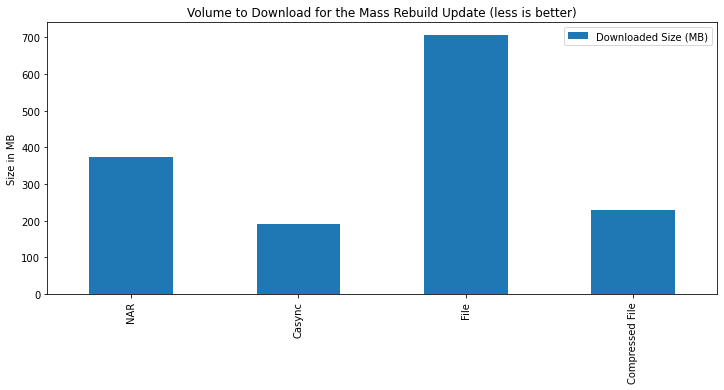

In [10]:
_ = mass_rebuild_results.plot.bar(figsize=(12,5), x="Name",y="Downloaded Size (MB)",title="Volume to Download for the Mass Rebuild Update (less is better)", xlabel="", ylabel="Size in MB")

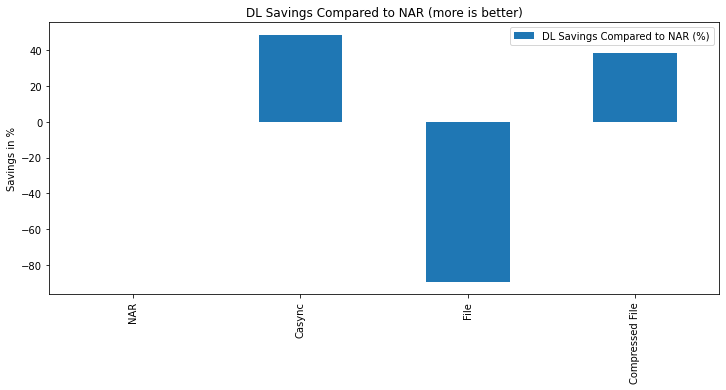

In [34]:
_ = mass_rebuild_results.plot.bar(figsize=(12,5), x="Name",y="DL Savings Compared to NAR (%)",title="DL Savings Compared to NAR (more is better)", xlabel="", ylabel="Savings in %")

We can see a massive performance gain for both Casync (48.4%) and xz-compressed files (38.4%). We can also see that compression plays a massive role in terms of substitution performance: the uncompressed files are doing almost 90% worse than the plain NAR substitution.

## 2. Firefox Bump

In this scenario, we're going to simulate a Firefox update. We took the Firefox 97.0 -> 97.0.1 bump [7e23a7fb8268f16e83ef60bbd2708e1d57fd49ef](https://github.com/NixOS/nixpkgs/commit/7e23a7fb8268f16e83ef60bbd2708e1d57fd49ef) as a test example.

In [11]:
firefox_bump_results = analyse_benchmark_results(b["firefoxBump"])

### NAR Substitution Performance

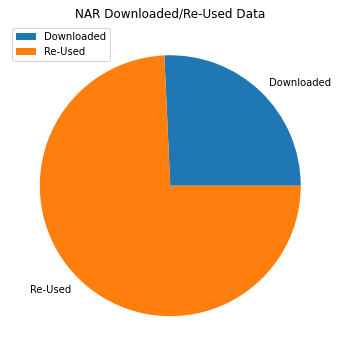

In [12]:
gen_perf_pie(firefox_bump_results, "NAR")

### Casync Substitution Performance

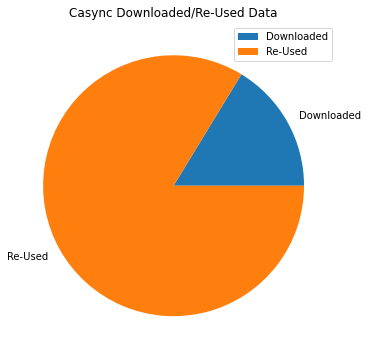

In [13]:
gen_perf_pie(firefox_bump_results, "Casync")

### File Substitution Performance

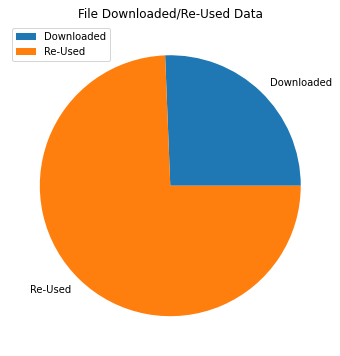

In [14]:
gen_perf_pie(firefox_bump_results, "File")

### Compressed File Substitution Performance

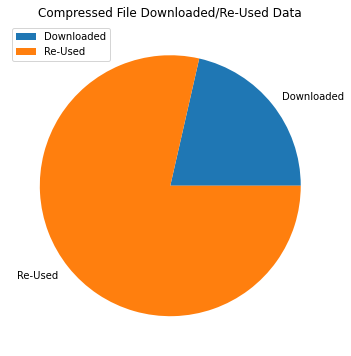

In [15]:
gen_perf_pie(firefox_bump_results, "Compressed File")

### Comparing the Substitution Techniques

In [16]:
firefox_bump_results

,Name,Closure Size (MB),Downloaded Size (MB),Re-used Size (MB),DL Savings Compared to NAR (%)
0,NAR,219.351904,56.431531,162.920373,0.000000
1,Casync,342.924949,55.870973,287.053976,0.993342
2,File,946.853440,249.259020,723.274748,-341.701675
3,Compressed File,260.424006,55.829510,204.594495,1.066817


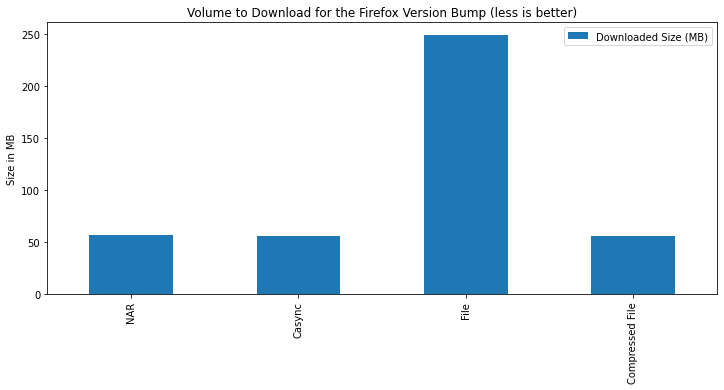

In [17]:
_ = firefox_bump_results.plot.bar(figsize=(12,5), x="Name",y="Downloaded Size (MB)",title="Volume to Download for the Firefox Version Bump (less is better)", xlabel="", ylabel="Size in MB")

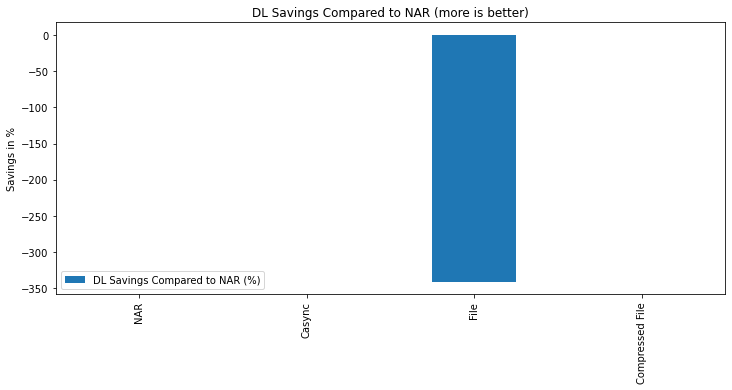

In [35]:
_ = firefox_bump_results.plot.bar(figsize=(12,5), x="Name",y="DL Savings Compared to NAR (%)",title="DL Savings Compared to NAR (more is better)", xlabel="", ylabel="Savings in %")

As expected, we don't see any gains (~1%) here.

## 3. Unstable to Stable Channel Jump

In this scenario, we're going to simulate a stable -> unstable jump for the same NixOS machine configuration we used in the mass rebuild simulation.

In [18]:
channel_jump_results = analyse_benchmark_results(b["channelJump"])

### NAR Substitution Performance

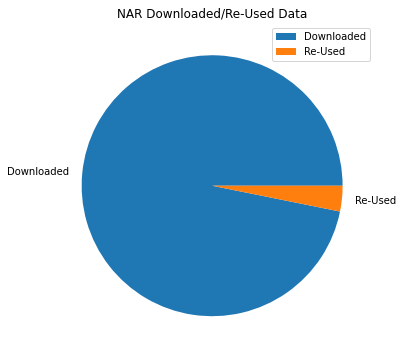

In [19]:
gen_perf_pie(channel_jump_results, "NAR")

### Casync Substitution Performance

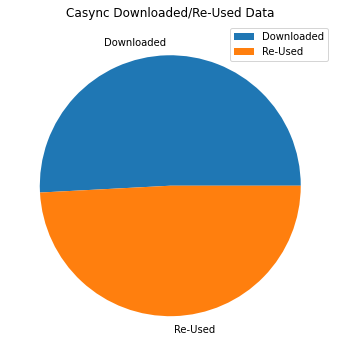

In [20]:
gen_perf_pie(channel_jump_results, "Casync")

### File Substitution Performance

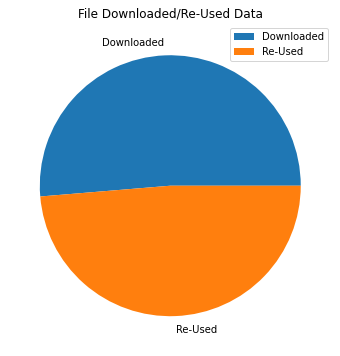

In [21]:
gen_perf_pie(channel_jump_results, "File")

### Compressed File Substitution Performance

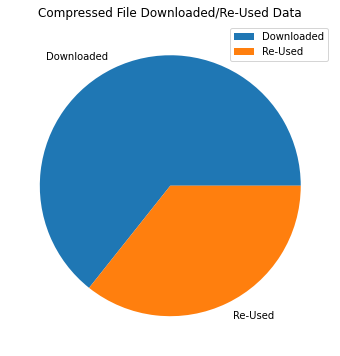

In [22]:
gen_perf_pie(channel_jump_results, "Compressed File")

### Comparing the Substitution Techniques

In [23]:
channel_jump_results

,Name,Closure Size (MB),Downloaded Size (MB),Re-used Size (MB),DL Savings Compared to NAR (%)
0,NAR,387.457979,375.167475,12.290504,0.000000
1,Casync,610.885612,310.540811,300.344801,17.226084
2,File,1658.069335,861.781638,817.549735,-129.705850
3,Compressed File,478.120248,307.478671,170.641577,18.042290


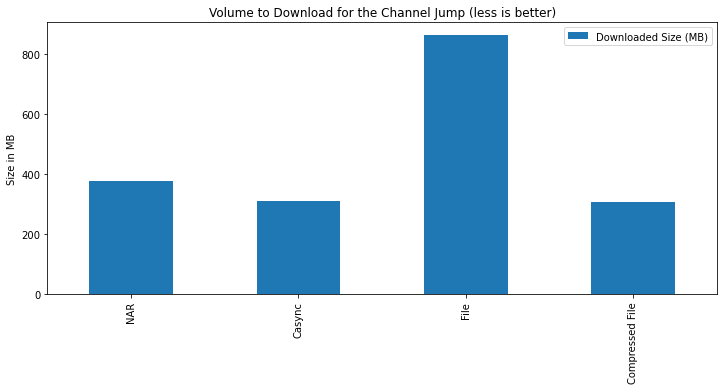

In [24]:
_ = channel_jump_results.plot.bar(figsize=(12,5), x="Name",y="Downloaded Size (MB)",title="Volume to Download for the Channel Jump (less is better)", xlabel="", ylabel="Size in MB")

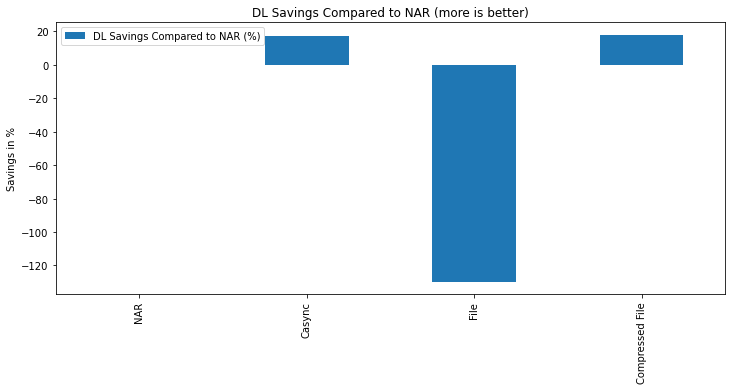

In [36]:
_ = channel_jump_results.plot.bar(figsize=(12,5), x="Name",y="DL Savings Compared to NAR (%)",title="DL Savings Compared to NAR (more is better)", xlabel="", ylabel="Savings in %")

I'm surprised on this one! I did not expect any gains, yet here we are, looking at a 18% improvement for compressed files, 17.2% improvement for Casync. While not amazing, it's big enough to be noticeable.